In [ ]:
#USE TENSORFLOW PLAYGROUND TO SIMULATE BEST PARAMETERS/HYPERPARAMETERS FOR MODEL (https://playground.tensorflow.org/)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_circles

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [ ]:
n_samples = 1000

X, y = make_circles(n_samples, noise = 0.03, random_state=42)

len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First ten values of X: \n{X[:10]}")
print(f"First ten values of y: \n{y[:10]}")
#looks like binary classification

First ten values of X: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]
 [-0.47964637  0.67643477]
 [-0.01364836  0.80334872]
 [ 0.77151327  0.14775959]
 [-0.16932234 -0.79345575]
 [-0.1214858   1.02150905]]
First ten values of y: 
[1 1 1 1 0 1 1 1 1 0]


In [ ]:
df = pd.DataFrame({"x1": X[:, 0],
                   "x2": X[:, 1],
                   "label": y})
df

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


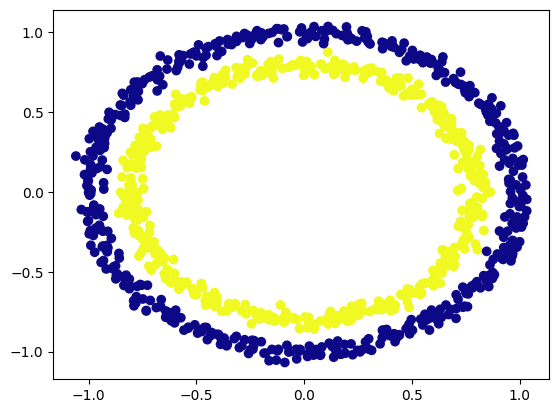

In [ ]:
plt.scatter(x=df['x1'], y=df['x2'], c=df['label'], cmap='plasma' )

In [ ]:
type(X), X.dtype

X=torch.from_numpy(X).type(torch.float32)
y=torch.from_numpy(y).type(torch.float32)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X.shape, y.shape
X_train.to(device)
y_train.to(device)
X_test.to(device)
y_test.to(device)


In [ ]:
#build model

#more verbose definition, allows for more flexibility and customization
class ToyCircleClassificationModel(nn.Module):
  def __init__(self):
    super().__init__()
    #create 2 nn.Linear() layers to handle data shapes
    self.layer1 = nn.Linear(in_features=2, out_features=5) #we have 2 input features, x1 and x2, and will upscale to 8 output features = 8 neurons in hidden layer
    self.layer2 = nn.Linear(in_features=5, out_features=1) #8 new inputs from learning patterns, 1 output feature: binary classification

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer2(self.layer1(x))

model_2=ToyCircleClassificationModel().to(device)
print(f"{model_2} currently on: {device}")


ToyCircleClassificationModel(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
) currently on: cpu


In [ ]:
#overriding model_2 with simpler, concise model definition, same functionality as prior model if model is relatively simple
model_2=nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
)
model_2

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
model_2.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.4207, -0.5175],
                      [-0.2912,  0.6842],
                      [-0.5860, -0.3092],
                      [-0.6306, -0.0744],
                      [-0.3939,  0.1494],
                      [-0.5940,  0.2915],
                      [-0.3910,  0.5857],
                      [ 0.1401, -0.3697]])),
             ('0.bias',
              tensor([ 0.3901,  0.1827,  0.6809,  0.6906,  0.1711, -0.3105,  0.0125,  0.5344])),
             ('1.weight',
              tensor([[-0.2392,  0.0808,  0.2234, -0.0490,  0.1240, -0.0022, -0.1472,  0.1465]])),
             ('1.bias', tensor([-0.2549]))])

In [ ]:
with torch.inference_mode():
  untrained_preds=model_2(X_test)
print("Untrained Predictions:",torch.round(untrained_preds[:10]))
print("Actual labels:",y_test[:10])
#pretty abysmal without training

Untrained Predictions: tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]])
Actual labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
#set up loss function and optimizer

loss_func=torch.nn.BCEWithLogitsLoss() #combines sigmoid activation function built-in with BCE loss in a single step, torch.nn.BCELoss() requires inputs to have gone through sigmoid activation function before calculating cross-entropy loss

optimizer=torch.optim.SGD(params=model_2.parameters(), lr=0.1)


In [ ]:
#accuracy function
def accuracy(y_test, y_preds):
  correct=torch.eq(y_test, y_preds).sum().item()
  return (correct/len(y_preds)) * 100
accuracy(y_test, untrained_preds)

0.0

In [ ]:
#use sigmoid only for binary classification
torch.manual_seed(42)
epochs=1000
for epoch in range(epochs):
  model_2.train()

  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) #logits -> pred probs -> pred labels

  loss=loss_func(y_logits, y_train)
  acc=accuracy(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2.eval()

  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits)).squeeze()

    test_loss = loss_func(test_logits, y_test)
    test_acc = accuracy(y_test, test_pred)

  if epoch%10==0:
    print(f"Epoch: {epoch} | Training Loss: {loss} | Testing Loss: {test_loss} | Training Accuracy: {acc}% | Testing Accuracy: {test_acc}%")
#our results are not very good, we are losing accuracy as epochs progress past a certain epoch, should we increase layers?

Epoch: 0 | Training Loss: 0.6948879361152649 | Testing Loss: 0.6945173144340515 | Training Accuracy: 50.0% | Testing Accuracy: 50.0%
Epoch: 10 | Training Loss: 0.6937289237976074 | Testing Loss: 0.6932328939437866 | Training Accuracy: 50.0% | Testing Accuracy: 50.0%
Epoch: 20 | Training Loss: 0.6934133768081665 | Testing Loss: 0.6929444074630737 | Training Accuracy: 50.0% | Testing Accuracy: 50.0%
Epoch: 30 | Training Loss: 0.6932942271232605 | Testing Loss: 0.6929439306259155 | Training Accuracy: 50.0% | Testing Accuracy: 50.0%
Epoch: 40 | Training Loss: 0.6932271718978882 | Testing Loss: 0.6930339336395264 | Training Accuracy: 50.0% | Testing Accuracy: 50.0%
Epoch: 50 | Training Loss: 0.693179190158844 | Testing Loss: 0.6931517720222473 | Training Accuracy: 49.125% | Testing Accuracy: 48.5%
Epoch: 60 | Training Loss: 0.6931414604187012 | Testing Loss: 0.693274974822998 | Training Accuracy: 40.875% | Testing Accuracy: 40.5%
Epoch: 70 | Training Loss: 0.6931111812591553 | Testing Loss:

In [ ]:
import requests
from pathlib import Path

#download helper functions from repo if not already downloaded
if Path("helper_functions.py").is_file():
  print("helper_function.py exists already in file path!")
else:
  print("Downloading helper_functions.py...")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

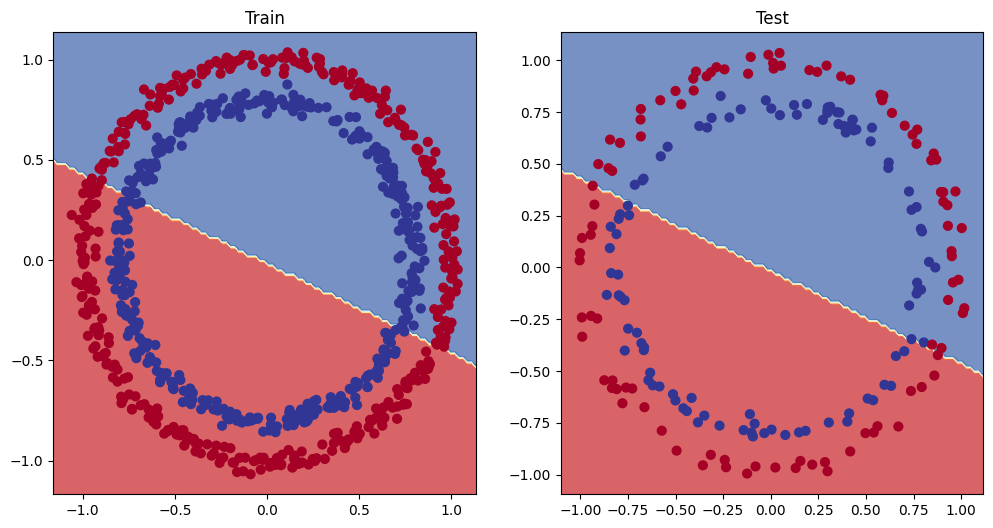

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_2, X_test, y_test)

In [ ]:
#improving the model - add layers?

class ToyCircleClassificationModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1=nn.Linear(in_features=2, out_features=8)
    self.layer2=nn.Linear(in_features=8, out_features=8)
    self.layer3=nn.Linear(in_features=8, out_features=1)
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer3(self.layer2(self.layer1(x)))

model_3 = ToyCircleClassificationModelV1().to(device)


In [ ]:
#initialize loss function and optimizer for new model training
loss_func=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)
epochs=1000
for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) #logits -> pred probs -> pred labels

  loss=loss_func(y_logits, y_train)
  acc=accuracy(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_3.eval()

  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits)).squeeze()

    test_loss = loss_func(test_logits, y_test)
    test_acc = accuracy(y_test, test_pred)

  if epoch%10==0:
    print(f"Epoch: {epoch} | Training Loss: {loss} | Testing Loss: {test_loss} | Training Accuracy: {acc}% | Testing Accuracy: {test_acc}%")
#results not very good still. Issue lies in fact that we are trying to code a linear model to train on nonlinear data.

Epoch: 0 | Training Loss: 0.6986392140388489 | Testing Loss: 0.6937922835350037 | Training Accuracy: 47.625% | Testing Accuracy: 51.5%
Epoch: 10 | Training Loss: 0.6964757442474365 | Testing Loss: 0.6926801204681396 | Training Accuracy: 48.875% | Testing Accuracy: 51.5%
Epoch: 20 | Training Loss: 0.6955786347389221 | Testing Loss: 0.692444920539856 | Training Accuracy: 49.375% | Testing Accuracy: 51.0%
Epoch: 30 | Training Loss: 0.6950634717941284 | Testing Loss: 0.6924083232879639 | Training Accuracy: 49.75% | Testing Accuracy: 51.5%
Epoch: 40 | Training Loss: 0.6946998834609985 | Testing Loss: 0.6924221515655518 | Training Accuracy: 49.625% | Testing Accuracy: 50.5%
Epoch: 50 | Training Loss: 0.6944177746772766 | Testing Loss: 0.6924552917480469 | Training Accuracy: 50.375% | Testing Accuracy: 51.0%
Epoch: 60 | Training Loss: 0.694190263748169 | Testing Loss: 0.6925005912780762 | Training Accuracy: 50.375% | Testing Accuracy: 50.5%
Epoch: 70 | Training Loss: 0.6940033435821533 | Test

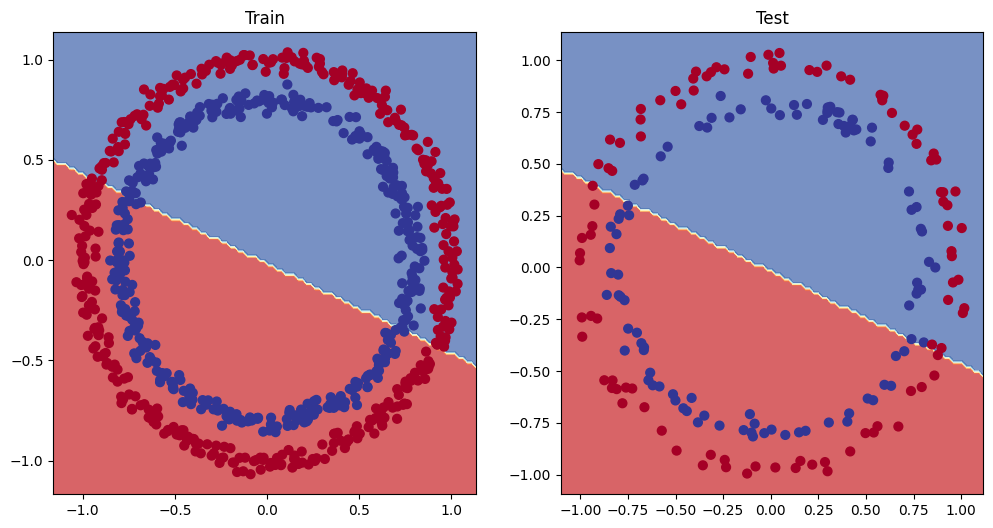

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)

In [ ]:
#we should use a non-linear activation function since our input data is nonlinear: ReLU!
# import torch
# from torch import nn
# import numpy as np
# import pandas as pd
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
class ToyCircleClassificationModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1=nn.Linear(in_features=2, out_features=5)
    self.layer2=nn.Linear(in_features=5, out_features=5)
    self.layer3=nn.Linear(in_features=5, out_features=1)
    self.relu=nn.ReLU()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x))))) #outputs of each layer passed to relu activation

model_4=ToyCircleClassificationModelV2().to(device)
model_4

ToyCircleClassificationModelV2(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=5, bias=True)
  (layer3): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)

epochs=10000
for epoch in range(epochs):
  model_4.train()

  y_logits=model_4(X_train).squeeze()
  y_preds=torch.round(torch.sigmoid(y_logits))

  loss=loss_func(y_logits, y_train)

  acc=accuracy(y_train, y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_4.eval()

  with torch.inference_mode():
    test_logits = model_4(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits)).squeeze()

    test_loss = loss_func(test_logits, y_test)
    test_acc = accuracy(y_test, test_pred)

  if epoch%100==0:
    print(f"Epoch: {epoch} | Training Loss: {loss} | Testing Loss: {test_loss} | Training Accuracy: {acc}% | Testing Accuracy: {test_acc}%")
#significant improvement!

Epoch: 0 | Training Loss: 0.7214900255203247 | Testing Loss: 0.7180036306381226 | Training Accuracy: 50.0% | Testing Accuracy: 50.0%
Epoch: 100 | Training Loss: 0.6903275847434998 | Testing Loss: 0.6919379234313965 | Training Accuracy: 56.125% | Testing Accuracy: 55.00000000000001%
Epoch: 200 | Training Loss: 0.6886691451072693 | Testing Loss: 0.6899645924568176 | Training Accuracy: 56.875% | Testing Accuracy: 56.49999999999999%
Epoch: 300 | Training Loss: 0.6865138411521912 | Testing Loss: 0.6874092221260071 | Training Accuracy: 57.375% | Testing Accuracy: 59.5%
Epoch: 400 | Training Loss: 0.6833891868591309 | Testing Loss: 0.6835718750953674 | Training Accuracy: 57.875% | Testing Accuracy: 59.5%
Epoch: 500 | Training Loss: 0.6790879964828491 | Testing Loss: 0.6782599091529846 | Training Accuracy: 57.125% | Testing Accuracy: 60.0%
Epoch: 600 | Training Loss: 0.6734306812286377 | Testing Loss: 0.6712139844894409 | Training Accuracy: 57.25% | Testing Accuracy: 60.0%
Epoch: 700 | Trainin

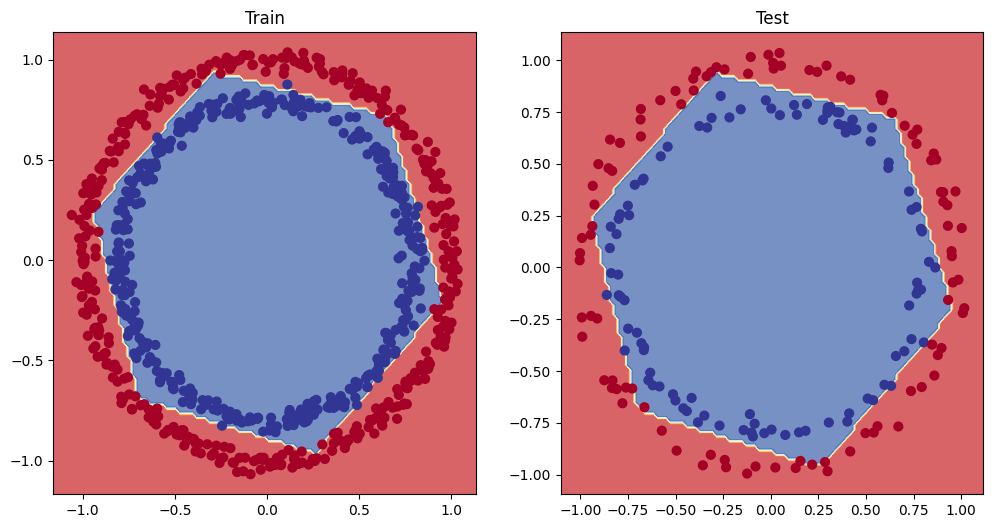

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_4, X_test, y_test)